In [3]:
using bamg
using HDF5
using BALUtils
using IterativeSolvers
using SparseArrays
using LinearAlgebra
using PyPlot
using RCall
using DataFrames

┌ Info: Precompiling bamg [38ddf468-022c-11e9-1596-a3da532e27b8]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273
┌ Info: Precompiling RCall [6f49c342-dc21-5d91-9882-a32aef131414]
└ @ Base loading.jl:1273


In [4]:
function readmat(filename, name)
    sz = h5read(filename, "$name/size")
    colptr = h5read(filename, "$name/colptr")
    nzval = h5read(filename, "$name/nzval")
    rowval = h5read(filename, "$name/rowval")
    SparseMatrixCSC(sz..., colptr, rowval, nzval)
end
prob = "bal-ladybug-1723"
dump_file = "../ba-problems/$prob/dump.h5"
ba = readbal("../ba-problems/$prob/problem.bal")

Bundle adjustment problem with 1723 cameras, 156502 points, 678718 observations

In [5]:
function metrics(xs, A, b, gt)
    residuals = map(x -> norm(b - A*x), xs)
    qs = map(x -> norm(0.5 * x'*A*x - x'*b), xs)
    tol = vcat(missing, collect(2:length(qs)) .* (qs[2:end] .- qs[1:end-1]) ./ qs[2:end])
    errs = map(x -> norm(x - gt), xs)
    residuals, qs, tol, errs
end
function run_prec(A, b, prec)
    x = zeros(size(b))
    xs = []
    function conv(it, iteration)
        push!(xs, copy(it.x))
        iteration > it.maxiter
    end
    cg(A, b, Pl=prec, maxiter=100, converged=conv)
    # for i in 1:100
    #     push!(xs, copy(x))
    #     cg!(x, A, b, Pl=prec, maxiter=1)
    # end
    xs
end
function test(A, scale, poses, b)
    mg = bamg.create_multigrid(ba, bamg.Options());
    bamg.update!(mg, A, scale, poses, nothing)
    xs_mg = run_prec(A, b, mg)
    
    B = bamg.block_diag(A, 9)
    xs_pb = run_prec(A, b, B)
    
    #gt = cg(A, b, Pl=mg, maxiter=200, tol=1e-14, verbose=true)
    gt = A \ b
    @show norm(b - A * gt)
    
    res_mg, qs_mg, tol_mg, errs_mg = metrics(xs_mg, A, b, gt)
    res_pb, qs_pb, tol_pb, errs_pb = metrics(xs_pb, A, b, gt)
    DataFrame(res=vcat(res_mg, res_pb), qs=vcat(qs_mg, qs_pb), errs=vcat(errs_mg, errs_pb),
              tol=vcat(tol_mg,tol_pb),
              prec=vcat(fill("multigrid", length(res_mg)), fill("pbjacobi", length(res_pb))),
              iter=vcat(1:length(res_mg), 1:length(res_pb)))
end

test (generic function with 1 method)

In [6]:
iter = 5
df = test(readmat(dump_file, "$iter/A"), h5read(dump_file, "$iter/scale"), h5read(dump_file, "$iter/poses"), h5read(dump_file, "$iter/b"));

norm(b - A * gt) = 2.6642758582827583e-12


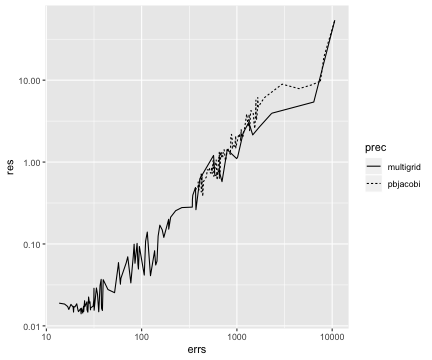

RObject{VecSxp}


In [9]:
R"library(ggplot2)"
R"ggplot($df, aes(x=iter, y=res, color=\"Residual (L2)\", linetype=prec)) + geom_line() +
  geom_line(aes(y=errs, color=\"Error (L2)\", linetype=prec)) + scale_y_log10() +
  geom_line(aes(y=tol, color=\"Nash-Sofer\", linetype=prec))
"
R"ggplot($df, aes(x=errs, y=res, linetype=prec)) + geom_line() + scale_y_log10() + scale_x_log10()
"
#R"ggsave(\"residual_vs_iteration.png\")"